In [1]:
import cifar100 as cf
import numpy as np
from plotutils import *
np.random.seed(1337)  

In [2]:
Xtrain , Ytrain , Xvalid , Yvalid, Xtest, Ytest = cf.loadCifar100(train_num= 45000, reshape = True, center= False, std = True )

#imgs, labels = cf.load_data(cf.file_path+"train",  reshape = True, one_hot = True, train_num=45000, center = True)
#Xtest, Ytest = cf.load_data(cf.file_path+"test", reshape = True)

#s = np.random.permutation(imgs.shape[0])                  # randomly shuffle the images and their corresponding labels
#imgs, labels   = imgs[s] , labels[s]
                                                          # Divide training data to training and validation sets#
#Xtrain, Ytrain = imgs[0:45000],labels[0:45000]            # Training : 90%
#Xvalid, Yvalid = imgs[45000:], labels[45000:]             # Validaiton : 10%

255
0


In [3]:
import numpy as np
import sandwichlayers as sl
import layers as ly

class ConvNet():
    
    def __init__(self, input_shape, reg=0 , alpha =1e-4 , weight_scale = 7e-2):
        self.num_layers  = 0
        self.num_filters = []                # num of filters per layer
        self.layers = []                     # layers stack
        self.filter_d = []                   # filter depth : is the input depth for this layer
        self.b = []
        self.w = []
        self.filter_d.append(input_shape[1])
        self.input_shape = input_shape
        
        self.mog = 0                         # Initialize momentum and accumalation values to zero
        self.ACCg = 0
        
        self.mob = 0
        self.ACCb = 0
        self.reg = reg
        self.alpha = alpha
        self.weight_scale = weight_scale
        pass
        
    def add(self,layer,filter_shape, conv_param, poolParam = None):
        
        filter_H, filter_W, filter_n = filter_shape
        padding,stride = conv_param['padding'] , conv_param['stride']
        input_shape = self.input_shape
        if (self.num_layers != 0):
            input_shape = self.out_shape

        N,C,H,W = input_shape
        out_h =  int ((W+2*padding-filter_W) / stride + 1)
        out_w = int ((H+2*padding-filter_W) / stride + 1)
        out_c = filter_n
        
        if (poolParam != None):
            out_w = int ((out_w-poolParam['F'])/poolParam['S'] +1)
            out_h = int ((out_h-poolParam['F'])/poolParam['S'] +1)

        self.out_shape = (N,out_c, out_h, out_w)
            
        self.num_layers = self.num_layers + 1
        
        self.num_filters.append(filter_n)
        self.filter_d.append(filter_n)                      # input depth for the next layer is the number of filters
        
        filter_C = self.filter_d[self.num_layers-1]
        
        fan_in =filter_W * filter_H * C
        print(fan_in)
        w = np.random.randn(filter_n, filter_C, filter_H, filter_W) * self.weight_scale #weight volume for this layer
        b = np.zeros(filter_n)                                                         # bias vector for this layer
        
        self.w.append(w)
        self.b.append(b)
        
        
        if (layer is 'ConvReLU'):
            self.layers.append({'layer': sl.ConvReLU() , 'param': conv_param, 'type' : 'conv_relu'})
        elif (layer is 'ConvReLUPool'):
            self.layers.append({'layer': sl.ConvReLUPool(poolParam['F'], poolParam['S']) , 'param': conv_param, 'type': 'convrelu_pool'})
     
    def addFC(self, num_hiddenlayers , nodes, num_classes ):               # to add last fully connected layers
        
        self.num_layers = self.num_layers +  num_hiddenlayers +1
        convout = self.out_shape[1] * self.out_shape[2] * self.out_shape[3]
        print('fc input' , convout)
        # first hidden layer
        w = np.random.randn(convout, nodes[0]) * self.weight_scale #input to the first hidden layer is the output of the last convo
        b = np.zeros((1,nodes[0]))
        self.w.append(w)
        self.b.append(b) 
        self.layers.append({'layer': sl.FCReLU(), 'param': None , 'type': 'FC'})
        # hidden layers
        for i in range(1,num_hiddenlayers):                     
            w = np.random.randn(nodes[i-1], nodes[i]) *np.sqrt(2.0/ nodes[i-1])
            b = np.zeros((1,nodes[i]))
            self.w.append(w)
            self.b.append(b)
            self.layers.append({'layer' : sl.FCReLU(), 'param': None , 'type': 'FC'})
        # output layer
        w = np.random.randn(nodes[num_hiddenlayers-1], num_classes) *np.sqrt(2.0/ nodes[num_hiddenlayers-1])
        b = np.zeros((1,num_classes))
        self.w.append(w)
        self.b.append(b)
        self.layers.append({'layer': ly.FClayer() , 'param': None, 'type': 'FC'})
            
    def forward(self, X,y):
        self.y = y
        input_x = X
        
        caches = np.empty(self.num_layers, dtype = object)
        
        for i in range(self.num_layers):
            layer = self.layers[i]['layer']
            param = self.layers[i]['param']
            layer_type = self.layers[i]['type'] 
                            
            if (layer_type is 'FC'):
                input_x , caches[i] = layer.forward(input_x, self.w[i], self.b[i])            
            else:
                input_x, caches[i] = layer.forward(input_x, self.w[i], self.b[i], param['padding'], param['stride'])
                            
        scores = input_x
        return scores, caches
    
    def forwardP(self, X,y, w,b):
        self.y = y
        input_x = X
        
        caches = np.empty(self.num_layers, dtype = object)
        
        for i in range(self.num_layers):
            layer = self.layers[i]['layer']
            param = self.layers[i]['param']
            layer_type = self.layers[i]['type'] 
                            
            if (layer_type is 'FC'):
                input_x , caches[i] = layer.forward(input_x, w[i], b[i])            
            else:
                input_x, caches[i] = layer.forward(input_x, w[i], b[i], param['padding'], param['stride'])
                            
        scores = input_x
        return scores, caches
        
    def backward(self, scores, caches):
        dx = np.empty(self.num_layers+1, dtype = object)
        dw = np.empty(self.num_layers, dtype = object)
        db = np.empty(self.num_layers, dtype = object)
            
        data_loss, dscores = self.softmax_loss(scores,self.y)
        dx[-1] = dscores
        for i in range(self.num_layers-1, -1,-1):
            layer , layer_type = self.layers[i]['layer'] , self.layers[i]['type']
            
            dx[i], dw[i],db[i] = layer.backward(dx[i+1], caches[i])
            # Then add regularization contribution to the deltas W
            dw[i] += self.reg * self.w[i] 
        
         # L2 Regularization
        Wsqr = np.asarray(self.w) * np.asarray(self.w)  
        wreg_loss = [np.sum(Wsqr[i]) for i in range(Wsqr.shape[0])]   # sum all the squared elements of W
        reg_loss  =  0.5*self.reg *np.sum(wreg_loss)                  # multiply by the regularization paramater
        
        loss = data_loss+ reg_loss
        return loss, dx,dw, db
        
    def updateWeights(self, dw,db):
        # Parameter update Adam
        beta1 = 0.9
        beta2 = 0.9
         # Momentum update
        self.mog = self.mog* beta1 + (1-beta1) * dw
        self.ACCg= beta2 * self.ACCg+ (1-beta2) * dw * dw
        self.w +=  -self.alpha * self.mog/ ( (self.ACCg*0.5) + 1*10**(-7))
        
        self.mob = self.mob * beta1 + (1-beta1) * db
        self.ACCb = beta2 * self.ACCb + (1-beta2) * db * db
        self.b += -self.alpha * self.mob/ ( (self.ACCb * 0.5) + 1 * 10**(-7))
        
    def softmax_loss(self,scores,correct_y):
        num_points = scores.shape[0]
        exp_scores = np.exp(scores)            # apply softmax function
        probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
        NLL = -np.log(probs[range(num_points) ,correct_y])   # negative log likelihood of the correct class probability
        data_loss = np.sum(NLL)/num_points
    
        dscores = probs
        dscores[range(num_points), correct_y] -= 1               # correct class probability - target(1)
        dscores = dscores / num_points                           # average the gradient of the batch
    
        return  data_loss, dscores
   
    def print_params(self):
        print("num layers: %d" %(self.num_layers))
        for i in range(self.num_layers):
            print("num filters : %d" %(i))

In [4]:
def train(model, Xtr, Ytr,Xval , Yval, alpha,reg, num_epochs,batch_size):
    
    model.reg = reg
    model.alpha = alpha
    tr_acc , val_acc  = [] , []
    loss_hist , loss_avg = [] , []    
    train_loss, valid_loss = [] , []
    
    Weights_hist = np.empty(num_epochs , dtype = object)
    bias_hist = np.empty(num_epochs, dtype = object)
    
    m = len(Ytr)
     # gradient descent loop
    for i in range(num_epochs):
        s = np.random.permutation(Xtr.shape[0])
        Xtr_shuffled = Xtr[s]
        Ytr_shuffled = Ytr[s]
            
        train_accs,loss = [] , []

        for k in range(0,m,batch_size): 
            Xtr_batch = Xtr_shuffled[k: k + batch_size, :,:,:] 
            Ytr_batch = Ytr_shuffled[k: k + batch_size]
            scores, caches = model.forward(Xtr_batch, Ytr_batch)                   # forward propagate the training data
            batchloss,dx,dw, db = model.backward(scores,caches)            # backpropagate to calculate partial derivative

            loss.append(batchloss)
            loss_hist.append(batchloss)
                
            model.updateWeights(dw,db)                                      # update Weight paramters
                
            predicted_class = np.argmax(scores, axis = 1)                
            train_acc = np.mean(Ytr_batch == predicted_class)
            train_accs.append(train_acc) 
            
            if (k is 200):
                print("iteration %d: loss %f , tr_acc %f " %(i, batchloss , train_acc))

                
        #validation set accuracy on batches cause memory suckkkkkkkkkkkkkk
        val_length = len(Yval)
        val_predicted = np.zeros(Yval.shape)
        batch_loss_val = []
        for z in range(0, val_length, 128):
            Xval_batch = Xval[z: z + batch_size, :,:,:] 
            Yval_batch = Yval[z: z + batch_size]
            val_scores, cahces  = model.forward(Xval_batch, Yval_batch)
            val_predicted_class = np.argmax(val_scores ,axis = 1 )
            val_predicted[z: z + batch_size] =  val_predicted_class
            validloss , probs = model.softmax_loss(val_scores, Yval_batch)               # calculate the cross entropy loss
            batch_loss_val.append(validloss)

        valid_acc = np.mean(val_predicted == Yval)
        val_acc.append(valid_acc)
        valid_loss.append(np.mean(batch_loss_val))
        
            
        avg_loss = np.mean(loss)            # average loss across all the batches
        train_loss.append(avg_loss)
            
        avg_train_acc = np.mean(train_accs)
        tr_acc.append(avg_train_acc)
            
        loss_avg.append(avg_loss)
        print("Epoch %d: loss %f , valid_loss %f, tr_acc %f , val_acc %f , lr %e, reg %e" %(i, avg_loss ,validloss, avg_train_acc ,valid_acc,alpha, reg))
            
        Weights_hist[i] = model.w
        bias_hist[i] = model.b    
    
    acc_cache = (tr_acc, val_acc)
    loss_cache = (loss_hist, train_loss, valid_loss)
    params = (Weights_hist, bias_hist)
            
    return acc_cache, loss_cache, params

In [5]:
# Specify model architecture
num_classes = 20

convnet = ConvNet((25,3,32,32))
convnet.add('ConvReLU', (3,3,32), {'padding': 1, 'stride': 1})
convnet.add('ConvReLUPool', (3,3,32), {'padding': 1, 'stride': 1}, {'F': 2, 'S' : 2})
convnet.add('ConvReLU', (3,3,64), {'padding': 1, 'stride': 1})
convnet.add('ConvReLUPool', (3,3,64), {'padding': 1, 'stride': 1}, {'F': 2, 'S' : 2})
convnet.add('ConvReLU', (3,3,128), {'padding': 1, 'stride': 1})
convnet.add('ConvReLUPool', (3,3,128), {'padding': 1, 'stride': 1}, {'F': 2, 'S' : 2})
convnet.addFC(1,[256], num_classes)

acc_cache, loss_cache, params = train(convnet, Xtrain, Ytrain, Xvalid, Yvalid, 1e-6, 1e-8,15, 128)
#train(convnet, X, y, X, y, 1e-7, 0, 10, 5)7
# 1st arch : 5e-6

27
288
288
576
576
1152
fc input 2048
Epoch 0: loss 2.331819 , valid_loss 1.827424, tr_acc 0.281334 , val_acc 0.359200 , lr 1.000000e-06, reg 1.000000e-08
Epoch 1: loss 1.916442 , valid_loss 1.650964, tr_acc 0.410940 , val_acc 0.421400 , lr 1.000000e-06, reg 1.000000e-08
Epoch 2: loss 1.697053 , valid_loss 1.621123, tr_acc 0.476094 , val_acc 0.454200 , lr 1.000000e-06, reg 1.000000e-08
Epoch 3: loss 1.541140 , valid_loss 1.616554, tr_acc 0.519864 , val_acc 0.472600 , lr 1.000000e-06, reg 1.000000e-08
Epoch 4: loss 1.392337 , valid_loss 1.477464, tr_acc 0.564421 , val_acc 0.488600 , lr 1.000000e-06, reg 1.000000e-08
Epoch 5: loss 1.262891 , valid_loss 1.317399, tr_acc 0.603037 , val_acc 0.489200 , lr 1.000000e-06, reg 1.000000e-08
Epoch 6: loss 1.137202 , valid_loss 1.565977, tr_acc 0.644918 , val_acc 0.498200 , lr 1.000000e-06, reg 1.000000e-08
Epoch 7: loss 1.017620 , valid_loss 1.459332, tr_acc 0.680033 , val_acc 0.506600 , lr 1.000000e-06, reg 1.000000e-08
Epoch 8: loss 0.904094 , v

In [6]:
# testing
w,b = params
batch_size = 128
m = len(Ytest)

predicted_classes = np.zeros(Ytest.shape)

for i in range(0,m,batch_size):
    Xtest_batch = Xtest[i: i + batch_size, :,:,:] 
    Ytest_batch = Ytest[i: i + batch_size]
    scores, _ = convnet.forwardP(Xtest_batch,Ytest_batch, w[10], b[10])
    predicted_class = np.argmax(scores, axis = 1)
    predicted_classes[i: i + batch_size] = predicted_class    
    
accr = np.mean(Ytest == predicted_classes)


In [7]:
print("ACCR",accr)

ACCR 0.5152


In [22]:
ccrn = cf.ccrn(predicted_classes, Ytest)
print("Correct Classification Rate")
for i in range(num_classes):
    print("class %d , ccrn %f" %(i , ccrn[i]) )

[10 10  0 ...  4  8  2]
[19. 11. 13. ...  4.  8.  2.]
Correct Classification Rate
class 0 , ccrn 0.338000
class 1 , ccrn 0.444000
class 2 , ccrn 0.730000
class 3 , ccrn 0.512000
class 4 , ccrn 0.560000
class 5 , ccrn 0.494000
class 6 , ccrn 0.558000
class 7 , ccrn 0.468000
class 8 , ccrn 0.354000
class 9 , ccrn 0.712000
class 10 , ccrn 0.680000
class 11 , ccrn 0.436000
class 12 , ccrn 0.444000
class 13 , ccrn 0.342000
class 14 , ccrn 0.596000
class 15 , ccrn 0.340000
class 16 , ccrn 0.382000
class 17 , ccrn 0.794000
class 18 , ccrn 0.558000
class 19 , ccrn 0.562000


In [9]:
import matplotlib.pyplot as plt
train_acc, val_acc = acc_cache
losshist, train_loss, val_loss = loss_cache


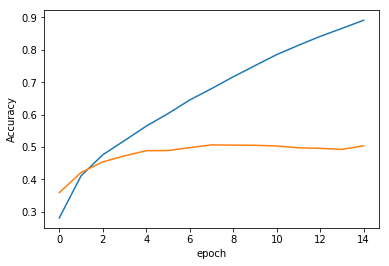

In [15]:
epochs = len(train_acc)
m = np.arange(epochs)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.plot(m, train_acc)
plt.plot(m, val_acc)
plt.show()

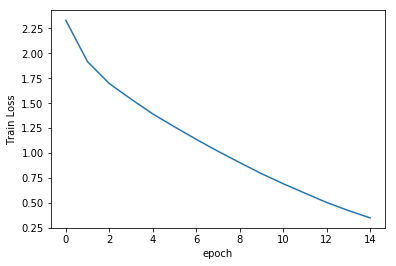

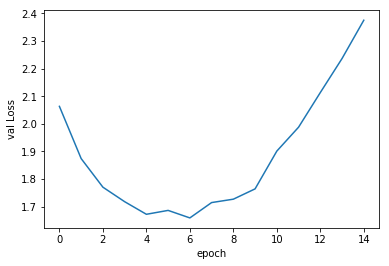

In [19]:
epochs = len(train_loss)
m = np.arange(epochs)
plt.xlabel('epoch')
plt.ylabel('Train Loss')
plt.plot(m, train_loss)
plt.show()
plt.xlabel('epoch')
plt.ylabel('val Loss')
plt.plot(m, val_loss)
plt.show()